In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import pathlib
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Sequential
import datetime
import tensorflow_hub as hub

In [16]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-03-19 23:49:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.127.128, 2a00:1450:4013:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  41.2MB/s    in 4.5s    

2023-03-19 23:49:34 (35.7 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [17]:
zipfile_ref = zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zipfile_ref.extractall()
zipfile_ref.close()

In [18]:
IMAGE_SHAPE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = IMAGE_SHAPE,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = IMAGE_SHAPE,
                                               class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [21]:
tf.random.set_seed = 42

In [22]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  return tensorboard_callback

In [23]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [24]:
transfermodel1 = Sequential([
    hub.KerasLayer(resnet_url, trainable = False, input_shape = INPUT_SHAPE, name = "feature_extraction_layer"),
    Dense(10, activation = "softmax", name = "output_layer")
])

transfermodel1.compile(loss = categorical_crossentropy,
                       optimizer = Adam(),
                       metrics = ["accuracy"])

history1 = transfermodel1.fit(train_data,
                              epochs = 5, 
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps = len(test_data),
                              callbacks=[create_tensorboard_callback("tensorflow_hub", "resnet50V2")])

Epoch 1/5
24/24 [==============================] - 24s 782ms/step - loss: 1.8185 - accuracy: 0.3880 - val_loss: 1.1528 - val_accuracy: 0.6416
Epoch 2/5
24/24 [==============================] - 17s 724ms/step - loss: 0.8537 - accuracy: 0.7453 - val_loss: 0.8675 - val_accuracy: 0.7136
Epoch 3/5
24/24 [==============================] - 22s 927ms/step - loss: 0.5925 - accuracy: 0.8280 - val_loss: 0.7596 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 17s 728ms/step - loss: 0.4563 - accuracy: 0.8787 - val_loss: 0.7088 - val_accuracy: 0.7612
Epoch 5/5
24/24 [==============================] - 19s 831ms/step - loss: 0.3679 - accuracy: 0.9200 - val_loss: 0.6870 - val_accuracy: 0.7756


<Axes: >

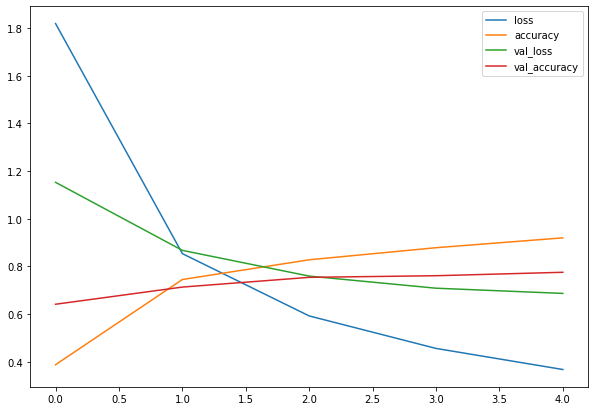

In [25]:
pd.DataFrame(history1.history).plot(figsize=(10,7))

In [26]:
transfermodel2 = Sequential([
    hub.KerasLayer(efficientnet_url, trainable = False, input_shape = INPUT_SHAPE, name = "feature_extraction_layer"),
    Dense(10, activation = "softmax", name = "output_layer")
])

transfermodel2.compile(loss = categorical_crossentropy,
                       optimizer = Adam(),
                       metrics = ["accuracy"])

history2 = transfermodel2.fit(train_data,
                              epochs = 5, 
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps = len(test_data),
                              callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnetb0")])

Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.8737 - accuracy: 0.4427 - val_loss: 1.3155 - val_accuracy: 0.7468
Epoch 2/5
24/24 [==============================] - 18s 752ms/step - loss: 1.0639 - accuracy: 0.7787 - val_loss: 0.8691 - val_accuracy: 0.8248
Epoch 3/5
24/24 [==============================] - 18s 761ms/step - loss: 0.7576 - accuracy: 0.8347 - val_loss: 0.6982 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 17s 744ms/step - loss: 0.6049 - accuracy: 0.8587 - val_loss: 0.6114 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 16s 694ms/step - loss: 0.5128 - accuracy: 0.8933 - val_loss: 0.5614 - val_accuracy: 0.8628


<Axes: >

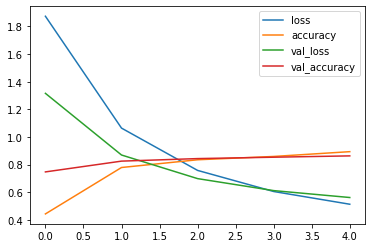

In [27]:
pd.DataFrame(history2.history).plot()

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 Vs ResNet50V2" \
--one_shot